In [1]:
import os
import shutil
import json

import matplotlib.pyplot as plt
import numpy as np
from monai.config import print_config
from monai.data import DataLoader, CacheDataset, partition_dataset
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AddChanneld,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

import torch
from torch.utils.data import ConcatDataset
import torch.nn as nn


import matplotlib.pyplot as plt

from math import floor

from typing import Union, List, Tuple

#################################################################

# Local imports

SOURCE_CODE_PATH = '/homes/yc7620/Documents/medical-vision-textural-bias/source_code/'

import sys
sys.path.append(SOURCE_CODE_PATH)

from filters_and_operators import WholeTumorTCGA 
from utils import ReCompose
from stylization_layers import GibbsNoiseLayer
# set determinism for reproducibility
set_determinism(seed=0)

print_config()

root_dir = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/' 
print('root_dir', root_dir)


MONAI version: 0.5.dev2113
Numpy version: 1.19.2
Pytorch version: 1.8.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: b3cc668c924b2a7e6b822416f4d920a098c27704

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.1.2
Tensorboard version: 2.5.0
gdown version: 3.12.2
TorchVision version: 0.9.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

root_dir /vol/bitbucket/yc7620/90_data/53_TCGA_data/


In [2]:
# Preprocessing transforms. Note we use wrapping artifacts. 

train_transform = ReCompose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys="image"),
        WholeTumorTCGA(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest")
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandSpatialCropd(
            keys=["image", "label"], roi_size=[128, 128, 64], random_size=False
        ),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd("image", factors=0.1, prob=0.5),
        RandShiftIntensityd("image", offsets=0.1, prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)

val_transform = ReCompose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys="image"),
        WholeTumorTCGA(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)


print('\n')
print('training transforms: ', train_transform.transforms,'\n')
print('validation transforms: ', val_transform.transforms, '\n')
###########################################################################

# Dataloading

# training
with open(os.path.join(root_dir, 'train_sequence_by_modality.json'), 'r') as f:
    data_seqs_4mods = json.load(f)

# split off training and validation     
train_seq_flair, _ = partition_dataset(data_seqs_4mods["FLAIR"], [0.9, 0.1], shuffle=True, seed=0)
train_seq_t1, _ = partition_dataset(data_seqs_4mods["T1"], [0.9, 0.1], shuffle=True, seed=0)
train_seq_t1gd, _ = partition_dataset(data_seqs_4mods["T1Gd"], [0.9, 0.1], shuffle=True, seed=0)
train_seq_t2, _ = partition_dataset(data_seqs_4mods["T2"], [0.9, 0.1], shuffle=True, seed=0)

# create training datasets
CACHE_NUM = 4

train_ds_flair = CacheDataset(train_seq_flair, train_transform, cache_num=CACHE_NUM)
train_ds_t1 = CacheDataset(train_seq_t1, train_transform, cache_num=CACHE_NUM)
train_ds_t1gd = CacheDataset(train_seq_t1gd, train_transform, cache_num=CACHE_NUM)
train_ds_t2 = CacheDataset(train_seq_t2, train_transform, cache_num=CACHE_NUM)

# combined dataset and dataloader
train_ds = ConcatDataset([train_ds_flair, train_ds_t1, train_ds_t1gd, train_ds_t2])
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

# validation out of dist
with open(os.path.join(root_dir, 'test_sequence_by_modality.json'), 'r') as f:
    val_data_seqs_4mods = json.load(f)

# validation modalities     
val_seq_flair  = val_data_seqs_4mods["FLAIR"]
val_seq_t1  = val_data_seqs_4mods["T1"]
val_seq_t1gd = val_data_seqs_4mods["T1Gd"]
val_seq_t2 = val_data_seqs_4mods["T2"]

val_ds_flair = CacheDataset(val_seq_flair, val_transform, cache_num=50)
val_ds_t1 = CacheDataset(val_seq_t1, val_transform, cache_num=50)
val_ds_t1gd = CacheDataset(val_seq_t1gd, val_transform, cache_num=50)
val_ds_t2 = CacheDataset(val_seq_t2, val_transform, cache_num=50)

# combined dataset and dataloader
val_ds = ConcatDataset([val_ds_flair, val_ds_t1, val_ds_t1gd, val_ds_t2])
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=4)

print('Data loaders created.\n')


Loading dataset:   0%|          | 0/4 [00:00<?, ?it/s]



training transforms:  (<monai.transforms.io.dictionary.LoadImaged object at 0x7f42f107bca0>, <monai.transforms.utility.dictionary.AddChanneld object at 0x7f42f107b880>, <filters_and_operators.WholeTumorTCGA object at 0x7f42f107bf40>, <monai.transforms.spatial.dictionary.Spacingd object at 0x7f42f107b970>, <monai.transforms.spatial.dictionary.Orientationd object at 0x7f42f107bfa0>, <monai.transforms.croppad.dictionary.RandSpatialCropd object at 0x7f42f10110d0>, <monai.transforms.spatial.dictionary.RandFlipd object at 0x7f42f1011100>, <monai.transforms.intensity.dictionary.NormalizeIntensityd object at 0x7f42f1011130>, <monai.transforms.intensity.dictionary.RandScaleIntensityd object at 0x7f42f1011220>, <monai.transforms.intensity.dictionary.RandShiftIntensityd object at 0x7f42f10112b0>, <monai.transforms.utility.dictionary.ToTensord object at 0x7f42f1011310>) 

validation transforms:  (<monai.transforms.io.dictionary.LoadImaged object at 0x7f42f107bc40>, <monai.transforms.utility.dict

Loading dataset: 100%|██████████| 22/22 [00:07<00:00,  3.00it/s]

Data loaders created.



In [9]:
class Gibbs_UNet(nn.Module):
    """ResUnet with Gibbs layer"""
    
    def __init__(self, alpha=None):
        super().__init__()
        
        self.gibbs = GibbsNoiseLayer(alpha)
        
        self.ResUnet = UNet(
        dimensions=3,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    )
        
    def forward(self,img):
        img = self.gibbs(img) 
        img = self.ResUnet(img)
        return img
    
device = torch.device("cuda:0")

# gibbs layer starting point
alpha = 0.75

model = Gibbs_UNet(alpha).to(device)
# load trained baseline ResUnet
baseline_path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/baseline_model_sourceDist_4mods_WT/baseline_model_sourceDist_4mods_WT.pth'
model.ResUnet.load_state_dict(torch.load(baseline_path))

loss_function = DiceLoss(to_onehot_y=False, sigmoid=True, squared_pred=True)

In [4]:
model.gibbs.alpha

CPU times: user 8 µs, sys: 5 µs, total: 13 µs
Wall time: 16.5 µs


tensor([0.7500], device='cuda:0', requires_grad=True)

In [5]:
batch_data = next(iter(train_loader))

inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )


In [43]:
%%time
outputs_0 = model(inputs)
loss_0 = loss_function(outputs_0, labels)

CPU times: user 51.3 ms, sys: 810 µs, total: 52.1 ms
Wall time: 18.4 ms


In [41]:
%%time
with torch.no_grad():
    outputs_0 = model(inputs)
    loss_0 = loss_function(outputs_0, labels)

CPU times: user 58 ms, sys: 4.86 ms, total: 62.9 ms
Wall time: 22.4 ms


In [17]:
h = 0.01
learning_rate = 0.02

old_alpha = model.gibbs.alpha.clone()
model.gibbs.alpha = old_alpha + h

In [18]:
model.gibbs.alpha

tensor([0.7600], device='cuda:0', grad_fn=<AddBackward0>)

In [19]:
outputs_h = model(inputs)
loss_h = loss_function(outputs_h, labels)
# approximate gradient
delta = (loss_h - loss_0) / h

In [20]:
delta

tensor(0.0085, device='cuda:0', grad_fn=<DivBackward0>)

In [21]:
learning_rate * delta

tensor(0.0002, device='cuda:0', grad_fn=<MulBackward0>)

In [22]:
old_alpha - learning_rate * delta

tensor([0.7498], device='cuda:0', grad_fn=<SubBackward0>)

In [32]:
@torch.no_grad()
def Gibbs_GD(inputs, labels, model, h = 0.01, learning_rate = 0.02):
#     with torch.no_grad():
    old_alpha = model.gibbs.alpha.clone()
    # loss at alpha
    outputs_0 = model(inputs)
    loss_0 = loss_function(outputs_0, labels)
    # loss at perturbed alpha
    model.gibbs.alpha = old_alpha + h
    outputs_h = model(inputs)
    loss_h = loss_function(outputs_h, labels)
    # approximate gradient
    delta = (loss_h - loss_0) / h
    # update alpha and model
    model.gibbs.alpha = old_alpha - learning_rate * delta

In [35]:
%%time
Gibbs_GD(inputs, labels, model, h = 0.01, learning_rate = 0.02)

CPU times: user 999 ms, sys: 46.7 ms, total: 1.05 s
Wall time: 422 ms


In [5]:
step = 0
h = 0.01
learning_rate = 0.02

for batch_data in train_loader:
        step += 1
        old_alpha = model.gibbs.alpha.clone()
#         gibbs_values.append(old_alpha.detach().item())
        

        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        # loss at alpha
        outputs_0 = model(inputs)
        loss_0 = loss_function(outputs_0, labels)
        # loss at perturbed alpha
        model.gibbs.alpha = old_alpha + h
        outputs_h = model(inputs)
        loss_h = loss_function(outputs_h, labels)
        # approximate gradient
        delta = (loss_h - loss_0) / h
        # update alpha
        model.gibbs.alpha = old_alpha - learning_rate * delta
        print(old_alpha)
        break
        if step > 10:
            break

tensor([0.7500], device='cuda:0', grad_fn=<CloneBackward>)
tensor([0.7501], device='cuda:0', grad_fn=<CloneBackward>)
tensor([0.7509], device='cuda:0', grad_fn=<CloneBackward>)


RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 11.93 GiB total capacity; 2.88 GiB already allocated; 24.62 MiB free; 2.90 GiB reserved in total by PyTorch)

In [4]:
data = val_ds[0]
img = data['image']
img.size()

torch.Size([1, 128, 128, 64])

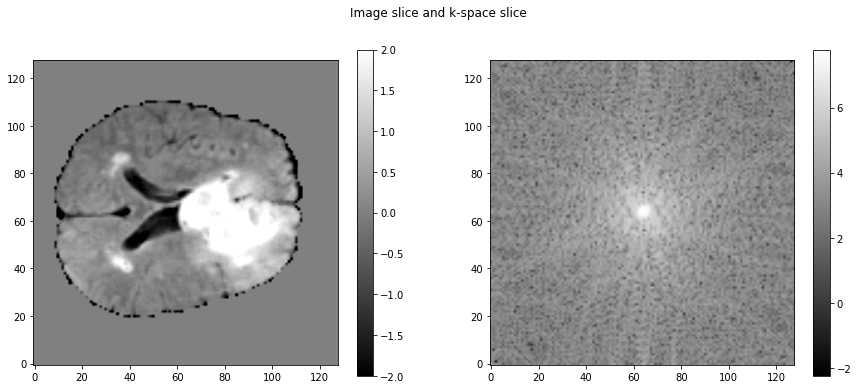

In [30]:
show_slice_and_fourier(img[0][:,:,32],level=0, window=4)

https://discuss.pytorch.org/t/how-to-get-gradient-wrt-a-parameter-defining-the-mask-size/124441/4

In [5]:
class Fourier:
    """
    Helper class storing Fourier mappings
    """
    
    @staticmethod
    def shift_fourier(x: torch.Tensor, n_dims: int) -> torch.tensor:
        """
        Applies fourier transform and shifts the zero-frequency component to the 
        center of the spectrum. Only the spatial dimensions get transformed.

        Args:
            x: image to transform.
            n_dims: number of spatial dimensions.
        Returns
            k: k-space data.
        """
        k: torch.tensor = torch.fft.fftshift(torch.fft.fftn(x, dim=tuple(range(-n_dims, 0))), 
                                               dim=tuple(range(-n_dims, 0)))
        return k
    
    @staticmethod
    def inv_shift_fourier(k: torch.Tensor, n_dims: int) -> torch.tensor:
        """
        Applies inverse shift and fourier transform. Only the spatial
        dimensions are transformed.

        Args:
            k: k-space data.
            n_dims: number of spatial dimensions. 
        Returns:
            x: tensor in image space.
        """
        x: torch.tensor = torch.fft.ifftn(
            torch.fft.ifftshift(k, dim=tuple(range(-n_dims, 0))), dim=tuple(range(-n_dims, 0))
        ).real
        return x
    
class GibbsNoiseLayer(nn.Module, Fourier):
    """
    The layer applies Gibbs noise to 2D/3D MRI images. 

    Args:
        alpha: Parametrizes the intensity of the Gibbs noise filter applied. Takes
            values in the interval [0,1] with alpha = 0 acting as the identity mapping.
        
    """

    def __init__(self, alpha=None) -> None:

        nn.Module.__init__(self)
        
        self.device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
        
        if alpha is None:
            self.alpha = nn.Parameter(torch.rand(1), requires_grad=True)
        else:
            alpha = min(max(alpha,0.),1.)
            self.alpha = nn.Parameter(torch.tensor(alpha), requires_grad=True)

    def forward(self, img: torch.Tensor) -> torch.Tensor:
        
        n_dims = len(img.shape[1:])
        # FT
        k = self.shift_fourier(img, n_dims)
        # build and apply mask
        k = self._apply_mask(k)
        # map back
        img = self.inv_shift_fourier(k, n_dims)

        return img

    def _apply_mask(self, k: torch.Tensor) -> torch.Tensor:
        """Builds and applies a mask on the spatial dimensions.

        Args:
            k (np.ndarray): k-space version of the image.
        Returns:
            masked version of the k-space image.
        """
        shape = k.shape[1:]
    
        center = (torch.tensor(shape, dtype=torch.float, device=self.device, requires_grad=True) - 1) / 2
        coords = torch.meshgrid(list(torch.linspace(0, i-1, i) for i in shape))
        # need to subtract center coord and then square for Euc distance
        dist_from_center = torch.sqrt(sum([(coord.to(self.device) - c)**2 for (coord, c) in zip(coords, center)]))
       
        alpha_norm = self.alpha * dist_from_center.max()
        norm_dist = dist_from_center / alpha_norm
        mask = norm_dist.where(norm_dist < 1, torch.zeros_like(alpha_norm))
        mask = mask.where(norm_dist > 1, torch.ones_like(alpha_norm))
        # add channel dimension into mask
        mask = torch.repeat_interleave(mask[None], k.size(0), 0)
        # apply binary mask

        k_masked = k * mask
        
        return k_masked

In [162]:
import torch

x = torch.linspace(-20, 19, 40)
Y, X = torch.meshgrid(x, x)
R = (X**2 + Y**2)**0.5

r_max = torch.tensor(15.0, requires_grad=True)

R_norm = R / r_max
mask = R_norm.where(R_norm>1, torch.zeros_like(r_max))
mask = mask.where(R_norm<1, torch.ones_like(r_max))

In [11]:
g = GibbsNoiseLayer(.3).cuda()
out = g(img.cuda())
out.requires_grad
g.alpha

Parameter containing:
tensor(0.3000, device='cuda:0', requires_grad=True)

supressing -Inf


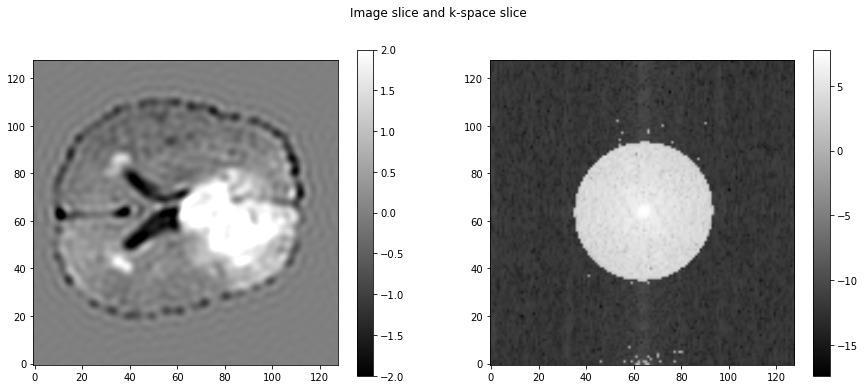

In [12]:
show_slice_and_fourier(out[0][:,:,32].detach().cpu(),level=0, window=4)

In [103]:
torch.tensor([1,0])
torch.rand(2,)/10

tensor([0.0971, 0.0216])

In [35]:
class Gibbs_UNet(nn.Module):
    """ResUnet with Gibbs layer"""
    
    def __init__(self, alpha=None):
        super().__init__()
        
        self.gibbs = GibbsNoiseLayer(alpha)
        
        self.ResUnet = UNet(
        dimensions=3,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    )
        
    def forward(self,img):
        img = self.gibbs(img) 
        img = self.ResUnet(img)
        return img
    
model = Gibbs_UNet(0.4)
model.to(device)
out = model.forward(img[0][None,:][None,].to(device))

In [39]:
out.requires_grad

True

In [29]:
list(model.parameters())[0]

Parameter containing:
tensor(0.4000, device='cuda:0', requires_grad=True)

In [9]:

# TODO change max_epochs to 180
max_epochs = 2  # 180
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

In [10]:
print('\n Training started... \n')

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print(
        #     f"{step}/{len(train_ds) // train_loader.batch_size}"
        #     f", train_loss: {loss.item():.4f}"
        #     )
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            dice_metric = DiceMetric(include_background=True, reduction="mean")
            post_trans = Compose(
                [Activations(sigmoid=True), AsDiscrete(threshold_values=True)]
            )
            metric_sum = metric_sum_tc = metric_sum_wt = metric_sum_et = 0.0
            metric_count = (
                metric_count_tc
            ) = metric_count_wt = metric_count_et = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = model(val_inputs)
                val_outputs = post_trans(val_outputs)
                # compute overall mean dice
                value, not_nans = dice_metric(y_pred=val_outputs, y=val_labels)
                not_nans = not_nans.item()
                metric_count += not_nans
                metric_sum += value.item() * not_nans
                # compute mean dice for TC
                value_tc, not_nans = dice_metric(
                    y_pred=val_outputs[:, 0:1], y=val_labels[:, 0:1]
                )
                not_nans = not_nans.item()
                metric_count_tc += not_nans
                metric_sum_tc += value_tc.item() * not_nans
                # compute mean dice for WT
                value_wt, not_nans = dice_metric(
                    y_pred=val_outputs[:, 1:2], y=val_labels[:, 1:2]
                )
                not_nans = not_nans.item()
                metric_count_wt += not_nans
                metric_sum_wt += value_wt.item() * not_nans
                # compute mean dice for ET
                value_et, not_nans = dice_metric(
                    y_pred=val_outputs[:, 2:3], y=val_labels[:, 2:3]
                )
                not_nans = not_nans.item()
                metric_count_et += not_nans
                metric_sum_et += value_et.item() * not_nans

                metric = metric_sum / metric_count
                metric_values.append(metric)
                metric_tc = metric_sum_tc / metric_count_tc
                metric_values_tc.append(metric_tc)
                metric_wt = metric_sum_wt / metric_count_wt
                metric_values_wt.append(metric_wt)
                metric_et = metric_sum_et / metric_count_et
                metric_values_et.append(metric_et)

                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(
                        model.state_dict(),
                        os.path.join(root_dir, f"best_metric_model_Gibbs{MASK_RADIUS}.pth"),
                    )
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                    f"\nbest mean dice: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )


 Training started... 

----------
epoch 1/2
epoch 1 average loss: 0.9310
----------
epoch 2/2
epoch 2 average loss: 0.9215
saved new best metric model
current epoch: 2 current mean dice: 0.2063 tc: 0.1340 wt: 0.4263 et: 0.0585
best mean dice: 0.2063 at epoch: 2
saved new best metric model
current epoch: 2 current mean dice: 0.2661 tc: 0.2203 wt: 0.4774 et: 0.1006
best mean dice: 0.2661 at epoch: 2
saved new best metric model
current epoch: 2 current mean dice: 0.2751 tc: 0.2343 wt: 0.4877 et: 0.1033
best mean dice: 0.2751 at epoch: 2
current epoch: 2 current mean dice: 0.2621 tc: 0.2168 wt: 0.4758 et: 0.0938
best mean dice: 0.2751 at epoch: 2
current epoch: 2 current mean dice: 0.2425 tc: 0.1974 wt: 0.4494 et: 0.0807
best mean dice: 0.2751 at epoch: 2
current epoch: 2 current mean dice: 0.2325 tc: 0.1840 wt: 0.4400 et: 0.0736
best mean dice: 0.2751 at epoch: 2
current epoch: 2 current mean dice: 0.2159 tc: 0.1737 wt: 0.4066 et: 0.0675
best mean dice: 0.2751 at epoch: 2
current epoch: 